# Feature Extraction & Engineering v1

This contains feature extraction and NaN values handling

Summary of the dataset: 

### Nodes:

- node_id
- Label: Account, Address, Customer, Derived Entity, External Entity
- Revenue Size Flag: low, mid_low, medium, mid_high, high
- Account ID String
- Address
- Person or Organisation: Person, Organisation
- Name
- Income Size Flag: low, medium, high
- CoreCaseGraphID
- ExtendedCaseGraphID
- testingFlag: 0, 1

### Edges:

- edge_id
- from_id
- to_id
- Label: has account, money transfer, is similar, has address
- Similarity Strength: weak, medium, strong
- Amount Flag: small, medium, large

In [71]:
import math, time, random, datetime
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [72]:
# Loading data

nodes = pd.read_csv('../data/polimi.case.graphs.vertices.csv', low_memory=False)

In [73]:
# Creating a new dataframe for convenience
df = nodes.copy()

### Target: Nodes ExtendedCaseGraphID

In [74]:
# This is the target feature

df['ExtendedCaseGraphID'].value_counts()

333.0     79
421.0     68
289.0     64
787.0     61
1140.0    56
          ..
3516.0     1
125.0      1
1395.0     1
2771.0     1
3075.0     1
Name: ExtendedCaseGraphID, Length: 3013, dtype: int64

In [75]:
df['ExtendedCaseGraphID'].notnull().sum()

32438

For both categorical and numeric features, this database contains a lot of NaN values.

This notebook walks through the steps taken to eliminate/reduce/change missing values with different techniques.

For Label, Revenue Size, Person or Organisation and Income Size, I will transform NaN values to a symbolic number like '-1'. For other fields, I will explain case by case my decisions.

## Categorical imbalances

### Node label

<AxesSubplot:xlabel='count', ylabel='Label'>

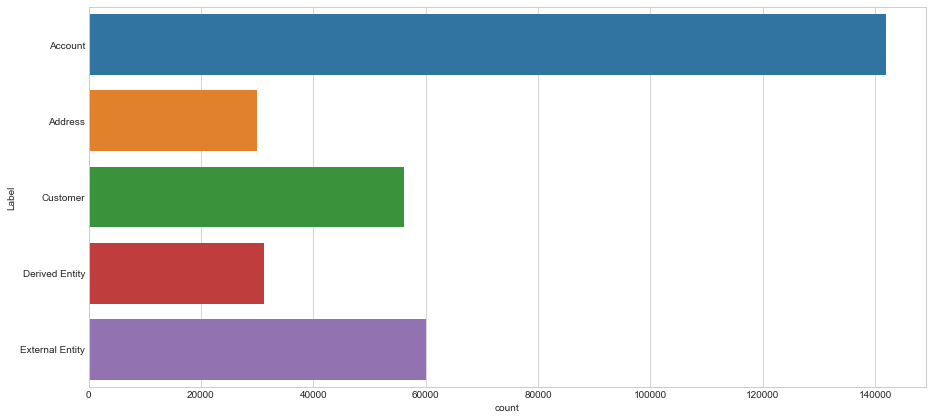

In [76]:
plt.figure(figsize=(15,7))
sns.countplot(y="Label", data=df)

Label kinds are balanced enough for an initial case. 

Maybe I will treat 'Account' labeled nodes separately in a future iteration.

### Revenue size flag

<AxesSubplot:xlabel='count', ylabel='Revenue Size Flag'>

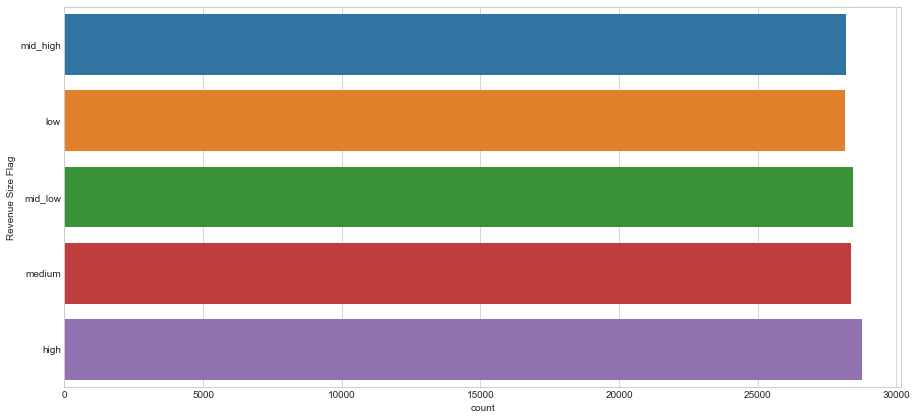

In [77]:
plt.figure(figsize=(15,7))
sns.countplot(y="Revenue Size Flag", data=df)

In [78]:
df['Revenue Size Flag'].isna().sum()

177500

Revenue flags are balanced. There are a lot of NaN values.

### Person or Organisation

<AxesSubplot:xlabel='count', ylabel='Person or Organisation'>

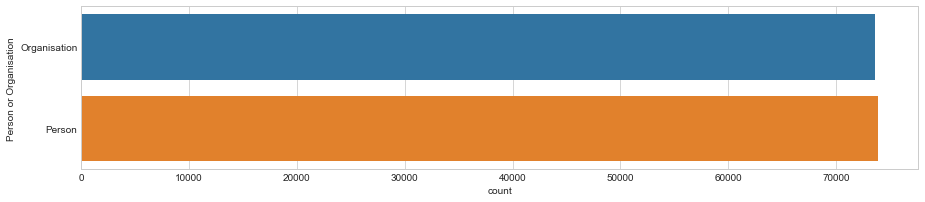

In [79]:
plt.figure(figsize=(15,3))
sns.countplot(y="Person or Organisation", data=df)

In [80]:
df['Person or Organisation'].isna().sum()

171876

### Income Size Flag

<AxesSubplot:xlabel='count', ylabel='Income Size Flag'>

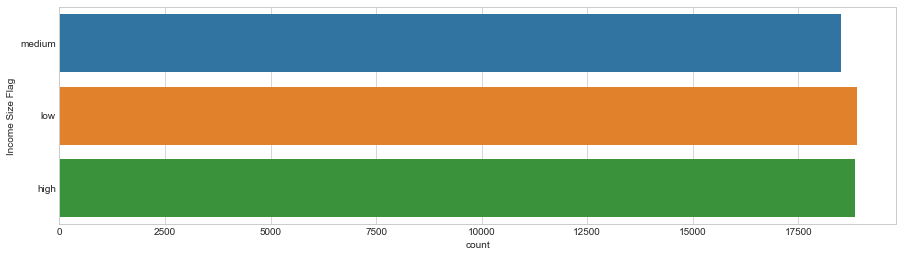

In [81]:
plt.figure(figsize=(15,4))
sns.countplot(y="Income Size Flag", data=df)

In [82]:
df['Income Size Flag'].isna().sum()

263150

# Categorical features: Mapping and Handling NaN values

In [83]:
cat_df = df.copy()

In [84]:
# Automatically map categorical features to numbers
# Good for Label, Revenue size, Person or Org, Income size

def automap_cats(flags, df):
    for flag in flags:
        cat_list = df[flag].astype('category').cat.categories.tolist()
        replace_cats = {flag : {k: v for k,v in zip(cat_list,list(range(1,len(cat_list)+1)))}}
        df.replace(replace_cats, inplace=True)

In [85]:
automap_cats(['Label', 'Revenue Size Flag', 'Person or Organisation', 'Income Size Flag'], cat_df)

In [86]:
cat_df

,node_id,Label,Revenue Size Flag,Account ID String,Address,Person or Organisation,Name,Income Size Flag,CoreCaseGraphID,ExtendedCaseGraphID,testingFlag
0,1502000,1,4.0,RvIOFQqK0E,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1502001,1,2.0,cSnM0hVDsm,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1502002,1,2.0,WAQWpZi4AD,NaN,NaN,NaN,NaN,2492.0,NaN,0.0
3,1502003,1,4.0,n5J9mBTeZc,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1502004,1,2.0,qxlAEuUm7P,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
319371,3001177742,5,NaN,NaN,NaN,2.0,gqDyJLC8DS,NaN,NaN,NaN,NaN
319372,3001177743,5,NaN,NaN,NaN,1.0,B5TdCmIf69,NaN,NaN,NaN,NaN
319373,3001177744,5,NaN,NaN,NaN,2.0,izrJE4sDpr,NaN,NaN,NaN,NaN
319374,3001177745,5,NaN,NaN,NaN,1.0,TKQfFZ3fkk,NaN,NaN,2030.0,0.0


## Removing NaN values from Revenue Size, Person or Org, Income Size:

In [87]:
cat_df['Revenue Size Flag'] = cat_df['Revenue Size Flag'].fillna(-1)
cat_df['Person or Organisation'] = cat_df['Person or Organisation'].fillna(-1)
cat_df['Income Size Flag'] = cat_df['Income Size Flag'].fillna(-1)

Some considerations:

For 'Person or Organisation' I could use one-hot encoding with LabelBinarizer since there are only 3 possibilities for the category: Person, Organisation, Missing. This could solve a problem where unequal weights are given to categories within a single feature.

While one-hot encoding solves the problem of unequal weights given to categories within a feature, it is not very useful when there are many categories, as that will result in formation of as many new columns, which can result in the curse of dimensionality.

In [88]:
cat_df

,node_id,Label,Revenue Size Flag,Account ID String,Address,Person or Organisation,Name,Income Size Flag,CoreCaseGraphID,ExtendedCaseGraphID,testingFlag
0,1502000,1,4.0,RvIOFQqK0E,NaN,-1.0,NaN,-1.0,NaN,NaN,NaN
1,1502001,1,2.0,cSnM0hVDsm,NaN,-1.0,NaN,-1.0,NaN,NaN,NaN
2,1502002,1,2.0,WAQWpZi4AD,NaN,-1.0,NaN,-1.0,2492.0,NaN,0.0
3,1502003,1,4.0,n5J9mBTeZc,NaN,-1.0,NaN,-1.0,NaN,NaN,NaN
4,1502004,1,2.0,qxlAEuUm7P,NaN,-1.0,NaN,-1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
319371,3001177742,5,-1.0,NaN,NaN,2.0,gqDyJLC8DS,-1.0,NaN,NaN,NaN
319372,3001177743,5,-1.0,NaN,NaN,1.0,B5TdCmIf69,-1.0,NaN,NaN,NaN
319373,3001177744,5,-1.0,NaN,NaN,2.0,izrJE4sDpr,-1.0,NaN,NaN,NaN
319374,3001177745,5,-1.0,NaN,NaN,1.0,TKQfFZ3fkk,-1.0,NaN,2030.0,0.0


## The last features left: Account ID, Address and Name

### Account ID String

In [89]:
cat_df['Account ID String'].isna().sum()

177500

It looks like there are a lot of NaN values for Account ID String.

From data exploration, I know that a missing account ID is related to being in a case.
This is why I cannot simply eliminate or interpolate new values for NaN for this column.

This kind of data is called MNAR: Missing not at random.

There isn't a perfect way to solve this problem. My first approach is to create a new "missing" category and replace NaN values this way. This does create a new problem which is class imbalance, but I'll deal with it later.

In [90]:
no_nan = cat_df.copy()

In [91]:
no_nan['Account ID String'] = no_nan['Account ID String'].fillna('missing')

In [92]:
no_nan['Account ID String'].value_counts()

missing       177500
rGpN4wBi8r         1
lq7a76eQXI         1
peRdqoLxDY         1
G9dTdIjP2w         1
               ...  
VL7Lp4d5JQ         1
H0NnmifZdk         1
PIKHf6QspI         1
uU6yOI9ShR         1
MQap7NyGEU         1
Name: Account ID String, Length: 141877, dtype: int64

### Address

In [93]:
cat_df['Address'].isna().sum()

289376

In [94]:
# same thing as Account ID... with even more NaN values

no_nan['Address'] = no_nan['Address'].fillna('missing')
no_nan['Address'].value_counts()

missing       289376
ac2AOsg5AW         1
3WCbAp14cr         1
zC9AZbKm8E         1
6dqQWrzJSA         1
               ...  
VEQWFP58Ju         1
BI6OE53T7P         1
EwVk5tu43C         1
KSs4NklHt6         1
J452rn52K0         1
Name: Address, Length: 30001, dtype: int64

### Name

In [95]:
print(f"Nodes with no name: {cat_df['Name'].isna().sum()} -> {cat_df['Name'].isna().sum()/cat_df.shape[0]*100}%")

Nodes with no name: 171876 -> 53.81619157356846%


Name is perhaps the most interesting feature of this dataset. 
From EDA, it looks like a lot of names are missing, and a lot of names are unreadable strings.
As it turns out, most of the names with a CoreCaseGraphID have an unreadable name.

This is why I can't ignore the Name column. It has implicit useful information about the cases.

There are a lot of strategies to handle this. As a first attempt, I will just keep all names and add a 'missing' column as I did for Account ID and Address.

A good strategy might be to use a model to evaluate if 'Name' is 'readable' vs if it's just a random string. Then I could add a column like 'Is readable' True or False

In [96]:
# First attempt: create 'missing' name:

no_nan['Name'] = no_nan['Name'].fillna('missing')
no_nan['Name'].value_counts()

missing           171876
THE BEARER          1377
BEARER                33
FORMIA LIMITED        30
The Bearer            29
                   ...  
QeajVKZWhR             1
jBYOAxtHtq             1
WEg7ke7fS9             1
Zhu Shuang Yan         1
BKENDZNSTT             1
Name: Name, Length: 143487, dtype: int64

## Removing NaN values from CoreCaseGraphID & ExtendedCaseGraphID

This is a little more delicate.

First attempt: just fillna(0)

Note: the field testingFlag can contain NaNs because I will drop the column while creating train/test split.

In [104]:
no_nan['CoreCaseGraphID'] = no_nan['CoreCaseGraphID'].fillna(0)
no_nan['ExtendedCaseGraphID'] = no_nan['ExtendedCaseGraphID'].fillna(0)

In [105]:
no_nan

,node_id,Label,Revenue Size Flag,Account ID String,Address,Person or Organisation,Name,Income Size Flag,CoreCaseGraphID,ExtendedCaseGraphID,testingFlag
0,1502000,1,4,RvIOFQqK0E,missing,-1,missing,-1,0.0,0.0,NaN
1,1502001,1,2,cSnM0hVDsm,missing,-1,missing,-1,0.0,0.0,NaN
2,1502002,1,2,WAQWpZi4AD,missing,-1,missing,-1,2492.0,0.0,0.0
3,1502003,1,4,n5J9mBTeZc,missing,-1,missing,-1,0.0,0.0,NaN
4,1502004,1,2,qxlAEuUm7P,missing,-1,missing,-1,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
319371,3001177742,5,-1,missing,missing,2,gqDyJLC8DS,-1,0.0,0.0,NaN
319372,3001177743,5,-1,missing,missing,1,B5TdCmIf69,-1,0.0,0.0,NaN
319373,3001177744,5,-1,missing,missing,2,izrJE4sDpr,-1,0.0,0.0,NaN
319374,3001177745,5,-1,missing,missing,1,TKQfFZ3fkk,-1,0.0,2030.0,0.0


In [106]:
no_nan.isna().sum()

node_id                        0
Label                          0
Revenue Size Flag              0
Account ID String              0
Address                        0
Person or Organisation         0
Name                           0
Income Size Flag               0
CoreCaseGraphID                0
ExtendedCaseGraphID            0
testingFlag               279915
dtype: int64

## Change data types

In [107]:
no_nan.dtypes

node_id                     int64
Label                       int64
Revenue Size Flag           int64
Account ID String          object
Address                    object
Person or Organisation      int64
Name                       object
Income Size Flag            int64
CoreCaseGraphID           float64
ExtendedCaseGraphID       float64
testingFlag               float64
dtype: object

In [110]:
no_nan['Revenue Size Flag'] = no_nan['Revenue Size Flag'].astype('int64')
no_nan['Person or Organisation'] = no_nan['Person or Organisation'].astype('int64')
no_nan['Income Size Flag'] = no_nan['Income Size Flag'].astype('int64')

no_nan['CoreCaseGraphID'] = no_nan['CoreCaseGraphID'].astype('int64')
no_nan['ExtendedCaseGraphID'] = no_nan['ExtendedCaseGraphID'].astype('int64')

In [111]:
no_nan.dtypes

node_id                     int64
Label                       int64
Revenue Size Flag           int64
Account ID String          object
Address                    object
Person or Organisation      int64
Name                       object
Income Size Flag            int64
CoreCaseGraphID             int64
ExtendedCaseGraphID         int64
testingFlag               float64
dtype: object

## Export new data

In [112]:
def write_csv_df(path, filename, df):
    pathfile = os.path.normpath(os.path.join(path,filename))
    files_present = os.path.isfile(pathfile) 
    if not files_present:
        df.to_csv(pathfile, encoding='utf-8', index=False)
    else:
        overwrite = input("WARNING: " + pathfile + " already exists! Do you want to overwrite <y/n>? \n ")
        if overwrite == 'y':
            df.to_csv(pathfile, encoding='utf-8', index=False)
        elif overwrite == 'n':
            new_filename = input("Type new filename: \n ")
            write_csv_df(path,new_filename,df)
        else:
            print ("Not a valid input. Data is NOT saved!\n")

In [113]:
write_csv_df("../data/raw", "no_nan_data.csv", no_nan)

 y
